In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
merged_data = pd.read_csv("Latest_all_in_one.csv")

In [27]:
merged_data['MHSleep'] = merged_data[['Sleep_Apnea',
              'Insomnia', 'Restless_Legs', 'Sleep_Disturbance_Other']].sum(axis=1)

In [28]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'MHSleep']
mri_vars = [
    "RightEntorhinal",
    "RightTemporalPole",
    "RightParahippocampal",
    "RightInferiorTemporal",
    "RightMiddleTemporal",
    "RightFusiform",
    "RightInferiorParietal",
    "RightIsthmusCingulate",
    "RightBankssts",
    "RightPrecuneus",
    "RightHippocampus",
    "RightAmygdala",
    "RightAccumbensArea",
    "RightMedialOrbitofrontal",
    "RightPallidum",
    "RightCaudalMiddleFrontal",
    "RightPutamen",
    "RightRostralAnteriorCingulate",
    "RightParacentral",
    "RightPrecentral",
    "RightLingual",
    "LeftEntorhinal",
    "LeftHippocampus",
    "LeftFusiform",
    "LeftMiddleTemporal",
    "LeftParacentral",
    "RightInferiorLateralVentricle",
    "LeftInferiorLateralVentricle",
    "RightLateralVentricle",
    "LeftLateralVentricle",
]

In [29]:
merged_data

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,RightTemporalPole,RightParahippocampal,RightInferiorTemporal,RightMiddleTemporal,...,MH,NPIK,NPIKSEV,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2,MHSleep
0,3,0,0,0,0,791.846918,1078.037276,1512.146246,6716.630454,8350.166431,...,1,0.0,0.0,10.927769,-1.021,-1.144,-0.880,-1.368,-1.062,0
1,3,0,0,0,0,958.133790,938.695742,1614.977833,6975.019609,7541.152761,...,1,0.0,0.0,10.927769,-1.187,-0.674,-1.221,-1.638,-0.670,0
2,3,0,0,0,0,676.398197,1094.889167,1440.387527,6116.780815,7896.178469,...,1,0.0,0.0,10.927769,-0.914,-0.969,-0.548,-1.837,-1.034,0
3,3,0,0,0,0,442.103700,1037.524095,1379.850263,6111.576649,7557.134067,...,1,0.0,0.0,10.927769,-1.369,-1.511,0.739,-1.700,-1.605,0
4,5,0,0,0,0,2376.161479,1881.167048,2169.129587,9288.203483,10896.464856,...,0,0.0,0.0,12.273373,0.743,0.165,0.739,0.259,-0.152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,1425,0,0,0,0,1406.252121,2290.512715,1546.298629,10290.524783,11785.897409,...,2,0.0,0.0,0.004549,-1.661,-1.078,0.739,-2.517,-0.826,0
2084,1427,0,0,0,0,1868.036354,2135.917249,2043.228422,9407.406634,12729.944577,...,2,0.0,0.0,72.926002,-0.366,-1.746,-1.530,-0.492,-2.042,0
2085,1427,0,0,0,0,1568.588612,2109.721786,2000.099965,9038.817478,12770.942225,...,2,0.0,0.0,72.926002,-1.445,-1.642,-1.813,-1.640,-1.788,0
2086,1427,0,0,0,0,1723.941992,2188.880920,1989.621379,8826.900230,12048.758467,...,2,1.0,2.0,72.926002,-1.764,-1.625,-0.656,-0.946,-2.047,0


In [30]:
sociodemo_outcomes = ['Adjusted_Age', 'PTGENDER', 'PTEDUCAT','PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4','MH','BMI']

In [31]:
len(sociodemo_outcomes + mri_vars + cognitive_outcomes)

44

In [32]:
target_groups = {
    'MRI': mri_vars,
    'Psychometric': cognitive_outcomes,
    'Sociodemographic': sociodemo_outcomes
}

In [33]:
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr


def perform_granger_causality(df, var1, var2, max_lag=3):
    try:
        data = df[[var1, var2]].dropna()
        result_1 = grangercausalitytests(data, max_lag)
        p_val_1 = result_1[1][0]['ssr_ftest'][1]

        result_2 = grangercausalitytests(
            data[[var2, var1]].dropna(), max_lag)
        p_val_2 = result_2[1][0]['ssr_ftest'][1]

        return p_val_1, p_val_2
    except Exception as e:
        return np.nan, np.nan

In [34]:
def calculate_correlation(df, var1, var2):
    corr_df = df[[var1, var2]].dropna()

    corr_df[var1] = pd.to_numeric(corr_df[var1], errors='coerce')
    corr_df[var2] = pd.to_numeric(corr_df[var2], errors='coerce')

    corr_df = corr_df.dropna()

    if not corr_df.empty and len(corr_df) > 1:
        corr_value, p_value = pearsonr(corr_df[var1], corr_df[var2])
        return corr_value, p_value
    else:
        return np.nan, np.nan

In [35]:
cn_data = merged_data[merged_data['DX_bl'] == 'CN']
mci_data = merged_data[merged_data['DX_bl'] == 'LMCI']
ad_data = merged_data[merged_data['DX_bl'] == 'AD']

In [36]:
cn_data = cn_data.sort_values(by=['RID', 'VISCODE'])
mci_data = mci_data.sort_values(by=['RID', 'VISCODE'])
ad_data = ad_data.sort_values(by=['RID', 'VISCODE'])

In [37]:
print(f"CN Data Shape: {cn_data.shape}")
print(f"MCI Data Shape: {mci_data.shape}")
print(f"AD Data Shape: {ad_data.shape}")

CN Data Shape: (713, 55)
MCI Data Shape: (953, 55)
AD Data Shape: (422, 55)


In [38]:
group_data = {
    'CN': cn_data,
    'MCI': mci_data,
    'AD': ad_data
}

In [60]:
results_list = []
selected_viscodes = ['bl', 'm24']  

for group_name, group_df in group_data.items():
    print(f"Analyzing {group_name} Group...")

    group_df_filtered = group_df[group_df['VISCODE'].isin(selected_viscodes)]

    for sleep_var in sleep_vars:
        for outcome in mri_vars + cognitive_outcomes + sociodemo_outcomes:
            
            p_val_1, p_val_2 = perform_granger_causality(
                group_df, sleep_var, outcome
            )

            corr_value, corr_p_value = calculate_correlation(
                group_df_filtered, sleep_var, outcome
            )

            results_list.append({
                'Group': group_name,
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Metric': 'Correlation',
                'Value': corr_value,
                'p_value': corr_p_value
            })

            results_list.append({
                'Group': group_name,
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Metric': 'Sleep_to_Outcome',
                'Value': p_val_1,
                'p_value': p_val_1
            })

            results_list.append({
                'Group': group_name,
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Metric': 'Outcome_to_Sleep',
                'Value': p_val_2,
                'p_value': p_val_2
            })


Analyzing CN Group...

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0058  , p=0.9391  , df_denom=709, df_num=1
ssr based chi2 test:   chi2=0.0059  , p=0.9390  , df=1
likelihood ratio test: chi2=0.0059  , p=0.9390  , df=1
parameter F test:         F=0.0058  , p=0.9391  , df_denom=709, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0940  , p=0.9103  , df_denom=706, df_num=2
ssr based chi2 test:   chi2=0.1893  , p=0.9097  , df=2
likelihood ratio test: chi2=0.1892  , p=0.9097  , df=2
parameter F test:         F=0.0940  , p=0.9103  , df_denom=706, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0059  , p=0.9994  , df_denom=703, df_num=3
ssr based chi2 test:   chi2=0.0178  , p=0.9994  , df=3
likelihood ratio test: chi2=0.0178  , p=0.9994  , df=3
parameter F test:         F=0.0059  , p=0.9994  , df_denom=703, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         

In [61]:
mri_outcomes = list(mri_vars)
psychometric_outcomes = list(cognitive_outcomes)
sociodemographic_outcomes = list(
    sociodemo_outcomes)

In [62]:
results_df = pd.DataFrame(results_list)

In [63]:
results_df 

,Group,Sleep_Variable,Outcome,Metric,Value,p_value
0,CN,MHSleep,RightEntorhinal,Correlation,0.103421,0.050558
1,CN,MHSleep,RightEntorhinal,Sleep_to_Outcome,0.939130,0.939130
2,CN,MHSleep,RightEntorhinal,Outcome_to_Sleep,0.758355,0.758355
3,CN,MHSleep,RightTemporalPole,Correlation,0.104095,0.049065
4,CN,MHSleep,RightTemporalPole,Sleep_to_Outcome,0.393900,0.393900
...,...,...,...,...,...,...
1075,AD,NPIKSEV,MH,Sleep_to_Outcome,0.209319,0.209319
1076,AD,NPIKSEV,MH,Outcome_to_Sleep,0.215021,0.215021
1077,AD,NPIKSEV,BMI,Correlation,0.057276,0.407828
1078,AD,NPIKSEV,BMI,Sleep_to_Outcome,0.206110,0.206110


In [64]:
corr_df = results_df[results_df['Metric'] == 'Correlation']
corr_df 

,Group,Sleep_Variable,Outcome,Metric,Value,p_value
0,CN,MHSleep,RightEntorhinal,Correlation,0.103421,0.050558
3,CN,MHSleep,RightTemporalPole,Correlation,0.104095,0.049065
6,CN,MHSleep,RightParahippocampal,Correlation,0.071587,0.176542
9,CN,MHSleep,RightInferiorTemporal,Correlation,0.176134,0.000816
12,CN,MHSleep,RightMiddleTemporal,Correlation,0.023457,0.658251
...,...,...,...,...,...,...
1065,AD,NPIKSEV,Adjusted_Age,Correlation,-0.039227,0.570963
1068,AD,NPIKSEV,PTEDUCAT,Correlation,0.065342,0.344903
1071,AD,NPIKSEV,APOE4,Correlation,0.038427,0.578842
1074,AD,NPIKSEV,MH,Correlation,0.073958,0.284896


In [65]:
filtered_df = corr_df.dropna(subset=['Value', 'p_value'])

In [66]:
filtered_df = filtered_df[filtered_df['p_value'] < 0.05]

In [67]:
pivot_df = filtered_df.pivot_table(
    index=['Sleep_Variable', 'Outcome'],
    columns='Group',
    values='Value',
    aggfunc='first'
).reset_index()


In [68]:
pivot_df 

Group,Sleep_Variable,Outcome,AD,CN,MCI
0,MHSleep,ADNI_EF,NaN,NaN,0.110203
1,MHSleep,ADNI_EF2,NaN,NaN,0.095761
2,MHSleep,ADNI_LAN,NaN,0.156957,0.099111
3,MHSleep,Adjusted_Age,NaN,-0.150896,NaN
4,MHSleep,BMI,NaN,NaN,0.099553
...,...,...,...,...,...
68,NPIKSEV,RightMiddleTemporal,NaN,NaN,-0.101591
69,NPIKSEV,RightPrecentral,-0.151167,NaN,NaN
70,NPIKSEV,RightPrecuneus,NaN,NaN,-0.100216
71,NPIKSEV,RightRostralAnteriorCingulate,NaN,NaN,-0.115399


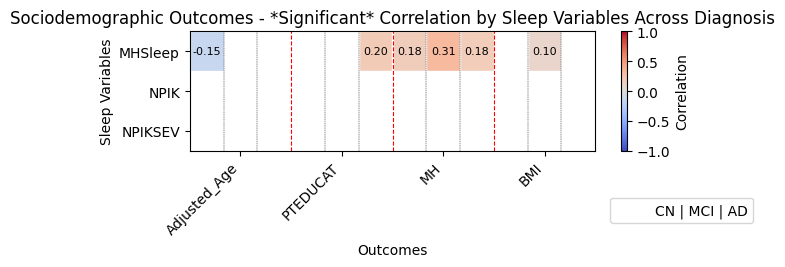

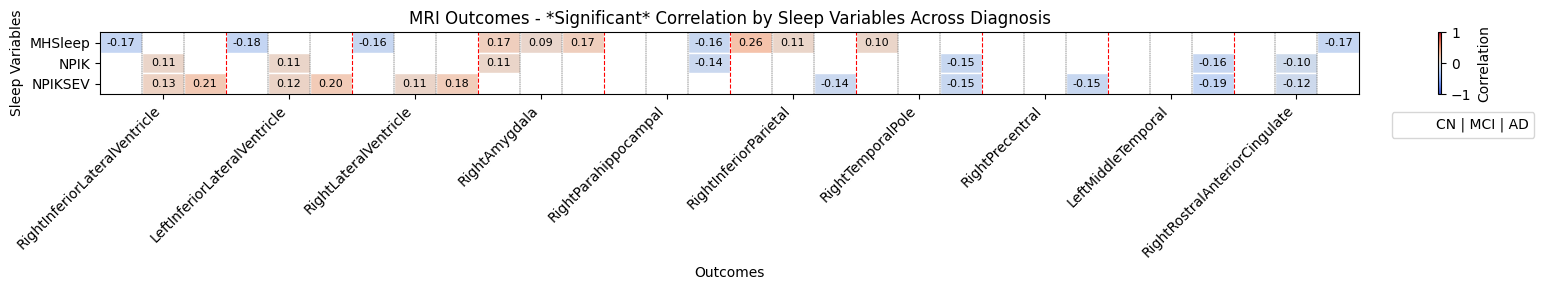

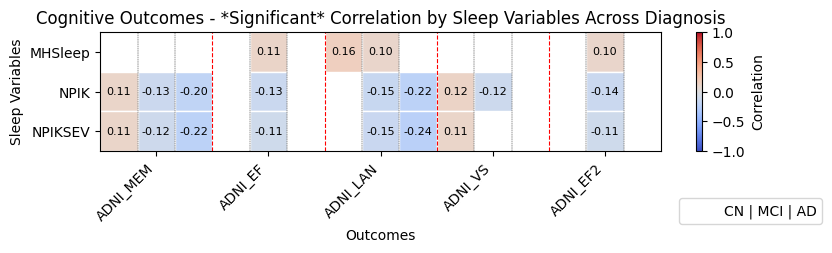

In [69]:
import matplotlib.patches as patches

mri_top10 = pivot_df[pivot_df['Outcome'].isin(mri_outcomes)].sort_values(
    by='AD', ascending=False)['Outcome'].unique()[:10]

outcome_categories = {
    "Sociodemographic Outcomes": list(sociodemographic_outcomes),
    "MRI Outcomes": mri_top10,
    "Cognitive Outcomes": list(psychometric_outcomes)
}

vmin, vmax = -1, 1
cmap = plt.cm.coolwarm
diagnoses = ['CN', 'MCI', 'AD']
num_diag = len(diagnoses)

for title, outcomes in outcome_categories.items():
    sleep_vars = pivot_df['Sleep_Variable'].unique()
    outcome_vars = [o for o in outcomes if o in pivot_df['Outcome'].values]

    fig, ax = plt.subplots(figsize=(1.7 * len(outcome_vars), 1 * len(sleep_vars)))
    ax.set_title(f'{title} - *Significant* Correlation by Sleep Variables Across Diagnosis')

    for i, sleep in enumerate(sleep_vars):
        for j, outcome in enumerate(outcome_vars):
            row = pivot_df[(pivot_df['Sleep_Variable'] == sleep) &
                           (pivot_df['Outcome'] == outcome)]
            if row.empty:
                continue

            x, y = j, i
            width = 1.0 / num_diag

            for k, diag in enumerate(diagnoses):
                val = row[diag].values[0] if diag in row.columns else np.nan
                if pd.isna(val):
                    continue

                color = cmap((val - vmin) / (vmax - vmin))
                rect = patches.Rectangle(
                    (x + k * width, y), width, 1, facecolor=color, edgecolor='white'
                )
                ax.add_patch(rect)
                ax.text(x + k * width + width / 2, y + 0.5, f'{val:.2f}',
                        ha='center', va='center', color='black', fontsize=8)

    for j in range(len(outcome_vars)):
        for k in range(1, num_diag): 
            ax.axvline(j + k / num_diag, color='black', linestyle='--', linewidth=0.3)
    
    for j in range(1,len(outcome_vars)):
        xpos = j
        ax.axvline(xpos,color='red',linestyle='--',linewidth=0.8)


    ax.set_xticks(np.arange(len(outcome_vars)) + 0.5)
    ax.set_xticklabels(outcome_vars, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(sleep_vars)) + 0.5)
    ax.set_yticklabels(sleep_vars)
    ax.set_xlim(0, len(outcome_vars))
    ax.set_ylim(0, len(sleep_vars))
    ax.invert_yaxis()
    ax.set_xlabel('Outcomes')
    ax.set_ylabel('Sleep Variables')


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Correlation')

    legend_labels = " | ".join(diagnoses)
    legend_patches = [patches.Patch(color='white', label=legend_labels)]
    ax.legend(handles=legend_patches, loc='center left',
              bbox_to_anchor=(1.02, -0.5), frameon=True)

    plt.tight_layout()
    plt.show()


In [70]:
granger_results = results_df[results_df['Metric'] != 'Correlation']

In [71]:
granger_results = granger_results.dropna(subset=['Value', 'p_value'])
granger_results = granger_results[granger_results['p_value'] < 0.05]

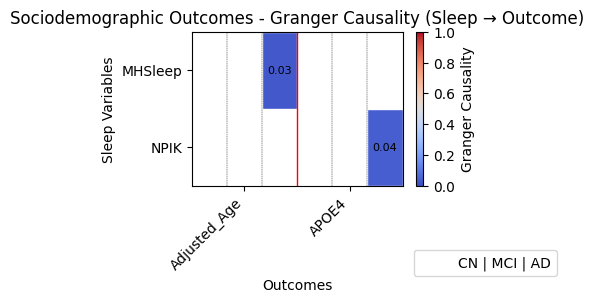

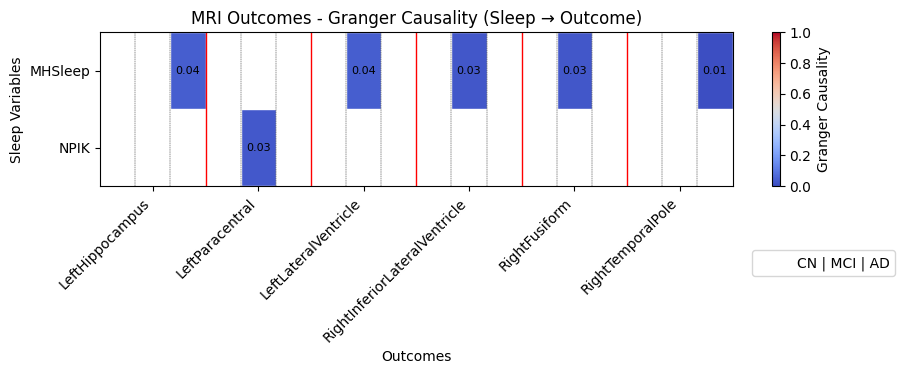

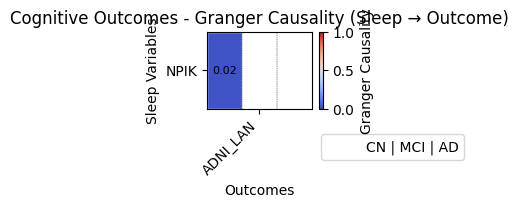

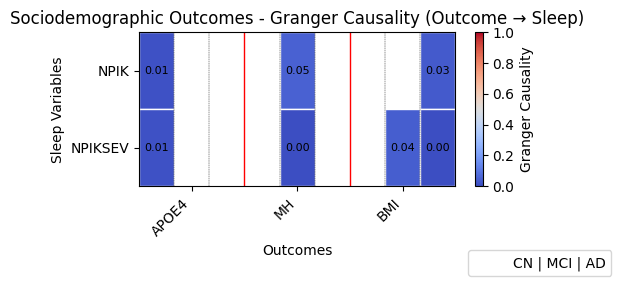

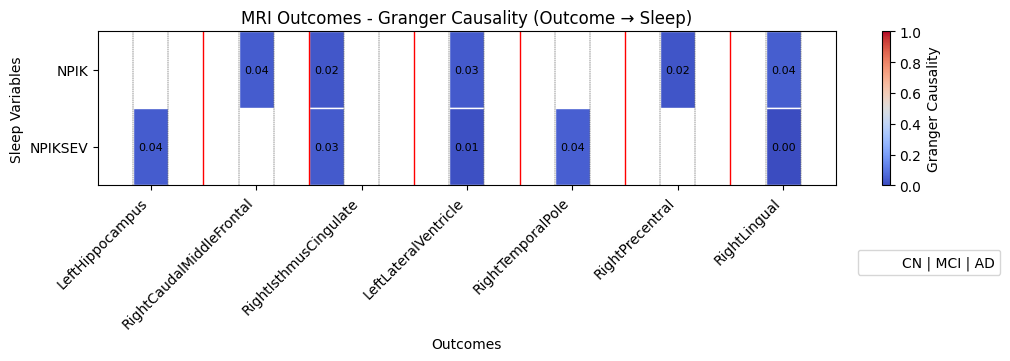

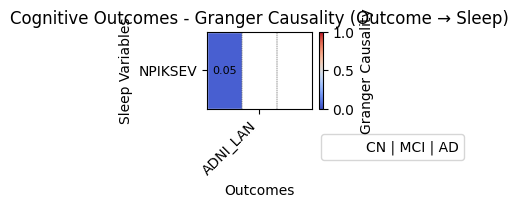

In [73]:
mri_top10 = granger_results[granger_results['Outcome'].str.contains("Right|Left")].groupby(
    'Outcome')['Value'].mean().sort_values(ascending=False).head(10).index.tolist()

sociodemo_outcomes = list(sociodemographic_outcomes)
for col in ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']:
    if col in sociodemo_outcomes:
        sociodemo_outcomes.remove(col)

psychometric_outcomes = list(cognitive_outcomes)
outcome_categories = {
    "Sociodemographic Outcomes": sociodemo_outcomes,
    "MRI Outcomes": mri_top10,
    "Cognitive Outcomes": psychometric_outcomes
}

vmin, vmax = 0, 1
cmap = plt.cm.coolwarm
diagnoses = ['CN', 'MCI', 'AD']


def plot_granger_matrix(data, direction_label):
    for title, outcomes in outcome_categories.items():
        filtered_df = data[data['Outcome'].isin(outcomes)]
        sleep_vars = filtered_df['Sleep_Variable'].unique()
        outcome_vars = [
            o for o in outcomes if o in filtered_df['Outcome'].values]

        fig, ax = plt.subplots(
            figsize=(1.7 * len(outcome_vars), 1 * len(sleep_vars)))
        ax.set_title(f'{title} - Granger Causality ({direction_label})')

        for i, sleep in enumerate(sleep_vars):
            for j, outcome in enumerate(outcome_vars):
                row = filtered_df[
                    (filtered_df['Sleep_Variable'] == sleep) &
                    (filtered_df['Outcome'] == outcome)
                ]
                if row.empty:
                    continue

                x, y = j, i
                width = 1.0 / len(diagnoses)

                for k, diag in enumerate(diagnoses):
                    val_row = row[row['Group'] == diag]
                    if val_row.empty or pd.isna(val_row['Value'].values[0]):
                        continue

                    val = val_row['Value'].values[0]
                    color = cmap((val - vmin) / (vmax - vmin))
                    rect = patches.Rectangle(
                        (x + k * width, y), width, 1, facecolor=color, edgecolor='white')
                    ax.add_patch(rect)
                    ax.text(
                        x + k * width + width / 2, y + 0.5, f'{val:.2f}',
                        ha='center', va='center', color='black', fontsize=8
                    )
        for j in range(len(outcome_vars)):
            for k in range(1, num_diag):
                ax.axvline(j + k / num_diag, color='black',
                        linestyle='--', linewidth=0.3)

        for j in range(1, len(outcome_vars)):
            xpos = j
            ax.axvline(x=xpos, color='red', linestyle='-', linewidth=1.0)

        ax.set_xticks(np.arange(len(outcome_vars)) + 0.5)
        ax.set_xticklabels(outcome_vars, rotation=45, ha='right')
        ax.set_yticks(np.arange(len(sleep_vars)) + 0.5)
        ax.set_yticklabels(sleep_vars)
        ax.set_xlim(0, len(outcome_vars))
        ax.set_ylim(0, len(sleep_vars))
        ax.invert_yaxis()
        ax.set_xlabel('Outcomes')
        ax.set_ylabel('Sleep Variables')

        sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
        cbar.set_label('Granger Causality')

        legend_patches = [patches.Patch(color='white', label='CN | MCI | AD')]
        ax.legend(handles=legend_patches, loc='center left',
                  bbox_to_anchor=(1.02, -0.5), frameon=True)

        plt.show()



sleep_to_outcome = granger_results[granger_results['Metric']
                                   == 'Sleep_to_Outcome']
outcome_to_sleep = granger_results[granger_results['Metric']
                                   == 'Outcome_to_Sleep']

plot_granger_matrix(sleep_to_outcome, 'Sleep → Outcome')
plot_granger_matrix(outcome_to_sleep, 'Outcome → Sleep')